In [1]:
# Configurations
limit=500


In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from google.cloud import bigquery

# Fetch Credentials - I created a key then literally dragged/dropped it to /content on google colab 
# Drew's Key
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'resource\local-receiver-341803-261a3b7beea6.json'
# Michael's Key
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'local-receiver-341803-9e38525e7b40.json'
# Steve's Key
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'resource\local-receiver-341803-54a43db29fa7.json'


# Build BigQuery Client
client = bigquery.Client()

In [3]:
#Get the dataset

# Query for Position Histories from BigQuery - change limit after we know it works
QUERY = ('SELECT lastTrainReporting FROM `local-receiver-341803.testTrainEvents.train-event-data` LIMIT ' + str(limit)) 
query_job = client.query(QUERY)

# Wait for job to finish
rows = query_job.result()

print("Num rows fetched: " + str(rows.total_rows))

Num rows fetched: 500


In [4]:
# Define Utility Functions to build additional data rows

# Create a dataframe row holding a record of position on the train.
def createPositionHistoryFrame(positionHistory) -> dict:
    # The time that the train was at the specific milepost
    # Record the position time as seconds from epoch to use in regression model
    positionTime = positionHistory.get('positionTime')
    # How fast the train is traveling
    speedMPH = positionHistory.get('speedMPH')
    # Milepost location information
    milepostLocation = positionHistory.get('milepostLocation')
    # The unique identifier of the subdivision
    subdivisionId = milepostLocation.get('subdivisionId')
    # The unique identifier fo the milepost
    milepostNumber = milepostLocation.get('milepost').get('milepostNumber')

    # Construct new dataframe record
    return {'PositionTime': positionTime, 'SpeedMPH': speedMPH, 
    'SubdivisionId': subdivisionId, 'MilepostNumber':milepostNumber}
     

# Create a dataframe row for the identifier information of the trani
def createTrainIdFrame(trainId) -> dict:
    trainSymbol = trainId.get('trainSymbol')
    return {'TrainSymbol': trainSymbol}

# Create data frame for train detail
def createTrainDetailFrame(trainDetail) -> dict:
    maximumTrainSpeed = trainDetail.get('maximumTrainSpeed')
    loadedCarCount = trainDetail.get('loadedCarCount')
    emptyCarCount = trainDetail.get('emptyCarCount')
    trainLength = trainDetail.get('trainLength')
    trailingTonnage = trainDetail.get('trailingTonnage')

    # Construct new dataframe record
    return {'MaximumTrainSpeed': maximumTrainSpeed, 'LoadedCarCount': loadedCarCount, 
    'EmptyCarCount': emptyCarCount, 'TrainLength':trainLength, 'TrailingTonnage':trailingTonnage}

In [6]:
# Fetch each position time and milepost
aggregateDataFrame = pd.DataFrame()

# For each returned record
for row in rows:
    lastTrainReporting = row.get('lastTrainReporting')

    trainIdFrame = createTrainIdFrame(lastTrainReporting.get('trainId'))
    trainDetailFrame = createTrainDetailFrame(lastTrainReporting)

    # Scan each position history
    for positionHistory in lastTrainReporting.get('positionHistoryList'):
        # The time that the train was at the specific milepost
        # Record the position time as seconds from epoch to use in regression model
        positionHistoryFrame = createPositionHistoryFrame(positionHistory)

        # Add additional records to 
        positionHistoryFrame.update(trainIdFrame)
        positionHistoryFrame.update(trainDetailFrame)

        # Append the row to the data frame.
        aggregateDataFrame = aggregateDataFrame.append(positionHistoryFrame, ignore_index = True)

#Return an item and drop from frame
date_time = pd.to_datetime(aggregateDataFrame.pop("PositionTime"), format='%Y-%m-%d %H:%M:%S')

print("date time: \n" + str(date_time))
print("cols: " + str(aggregateDataFrame.columns))

aggregateDataFrame.head()

date time: 
0      2022-04-02 01:55:06+00:00
1      2022-04-02 01:54:08+00:00
2      2022-04-02 01:53:34+00:00
3      2022-04-02 01:52:49+00:00
4      2022-04-02 01:51:51+00:00
                  ...           
2495   2022-04-05 03:24:18+00:00
2496   2022-04-05 03:19:18+00:00
2497   2022-04-05 03:19:11+00:00
2498   2022-04-05 03:14:19+00:00
2499   2022-04-05 03:09:19+00:00
Name: PositionTime, Length: 2500, dtype: datetime64[ns, UTC]
cols: Index(['SpeedMPH', 'SubdivisionId', 'MilepostNumber', 'TrainSymbol',
       'MaximumTrainSpeed', 'LoadedCarCount', 'EmptyCarCount', 'TrainLength',
       'TrailingTonnage'],
      dtype='object')


,SpeedMPH,SubdivisionId,MilepostNumber,TrainSymbol,MaximumTrainSpeed,LoadedCarCount,EmptyCarCount,TrainLength,TrailingTonnage
0,-11.0,106.0,766.9261,WSJGCZ,50.0,44.0,51.0,5205.0,7586.0
1,-10.0,595.0,279.0362,WSJGCZ,50.0,44.0,51.0,5205.0,7586.0
2,-9.0,595.0,279.1244,WSJGCZ,50.0,44.0,51.0,5205.0,7586.0
3,-7.0,595.0,279.2209,WSJGCZ,50.0,44.0,51.0,5205.0,7586.0
4,-3.0,595.0,279.3100,WSJGCZ,50.0,44.0,51.0,5205.0,7586.0


In [6]:
# Handle Encoding of the data
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column 'TrainSymbol'.
aggregateDataFrame['TrainSymbol'] = label_encoder.fit_transform(aggregateDataFrame['TrainSymbol'])

# Display Encoded Values
aggregateDataFrame.head()

NameError: name 'aggregateDataFrame' is not defined

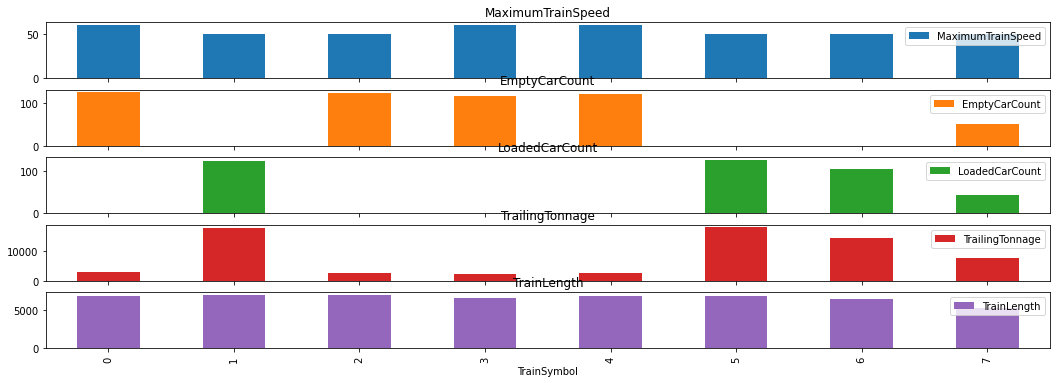

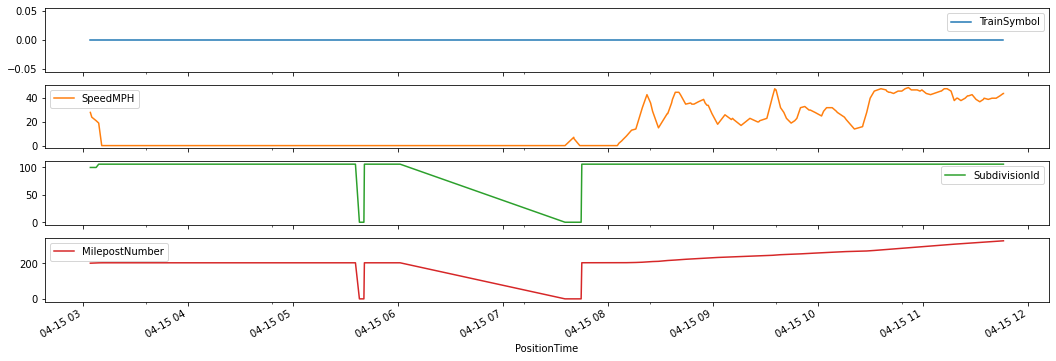

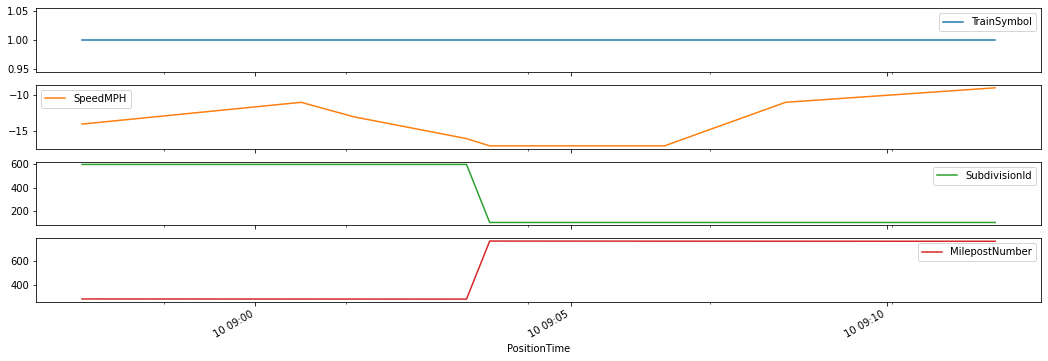

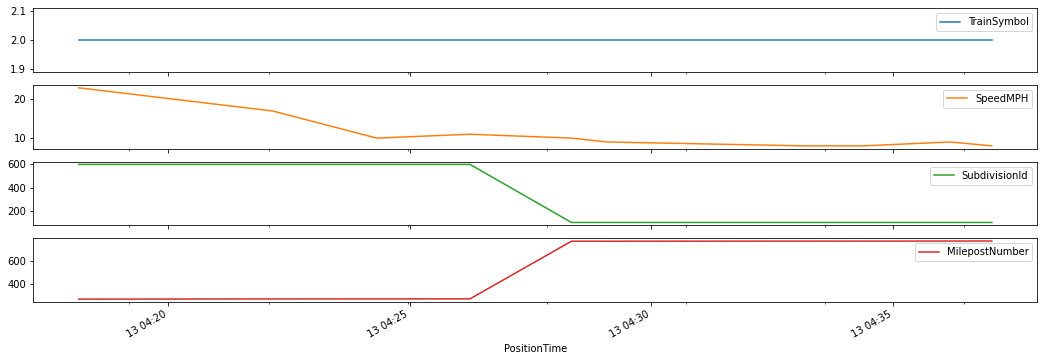

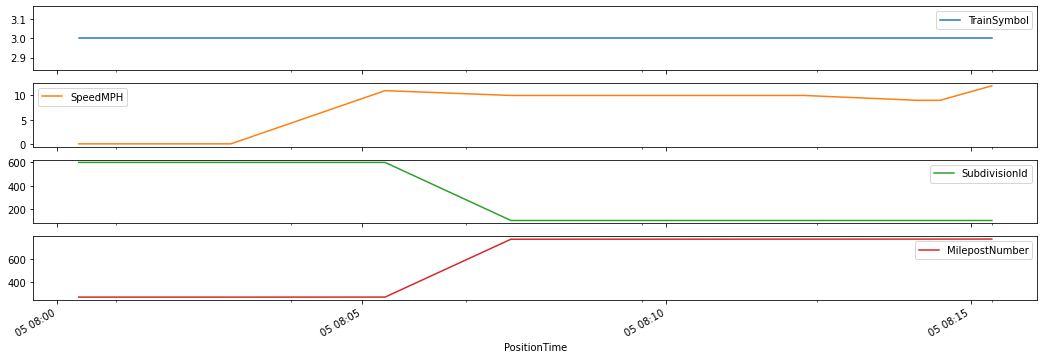

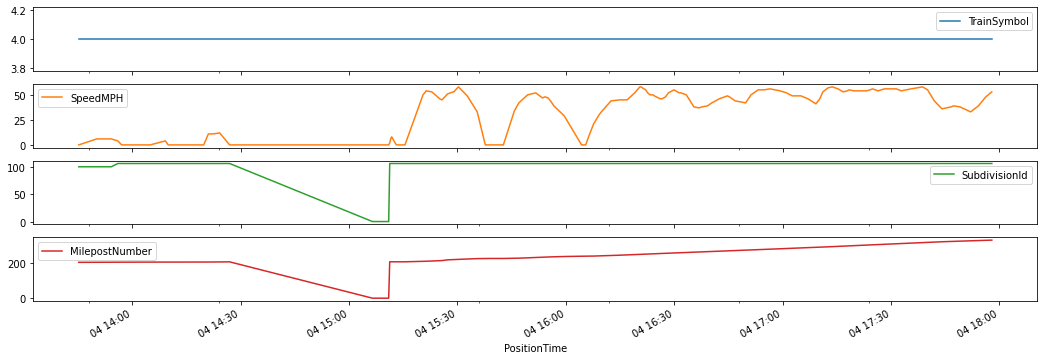

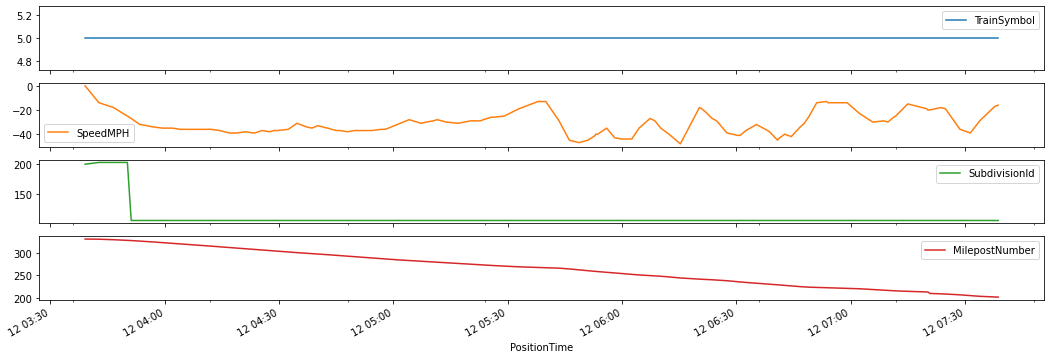

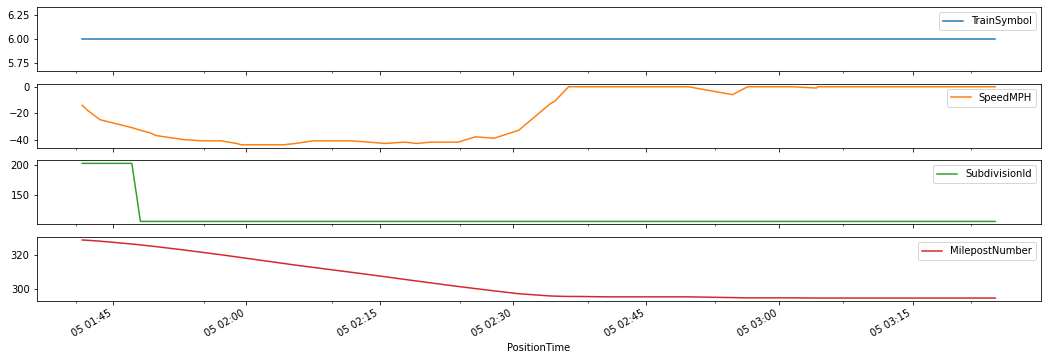

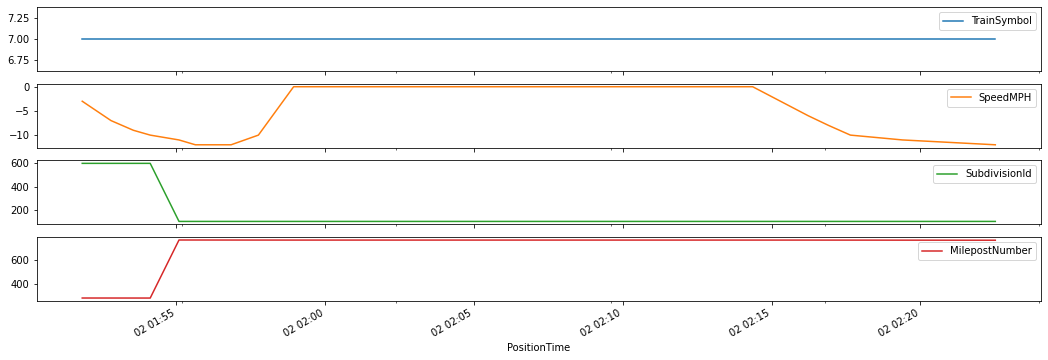

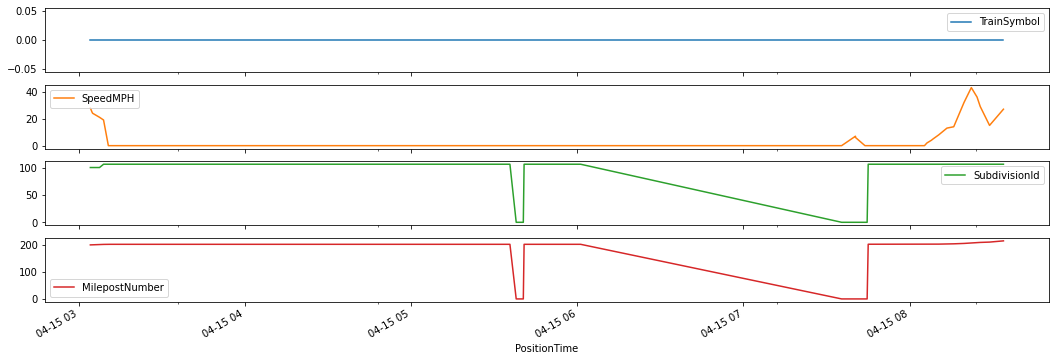

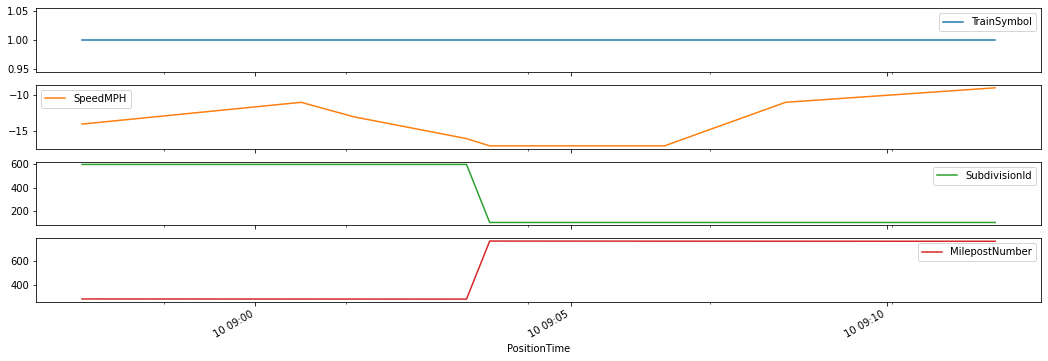

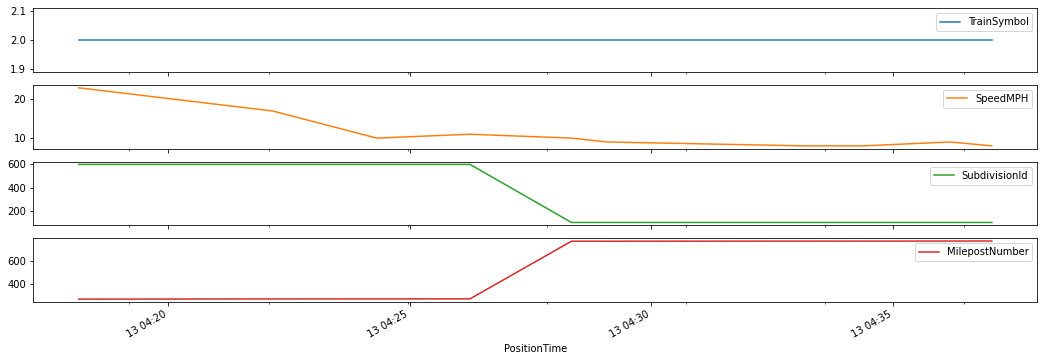

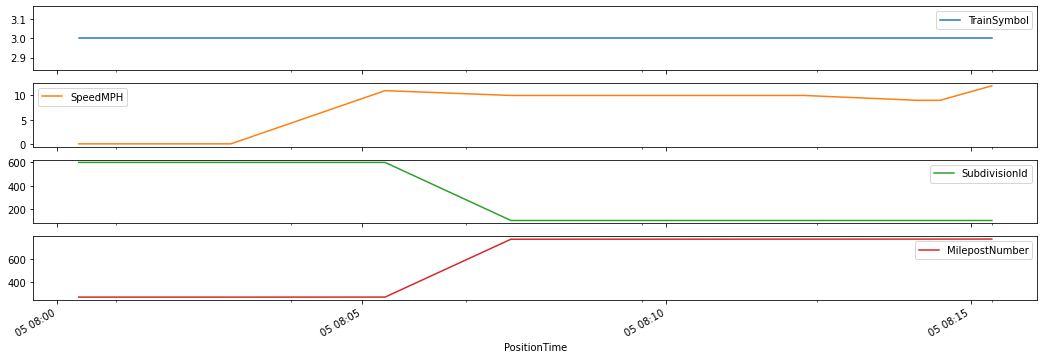

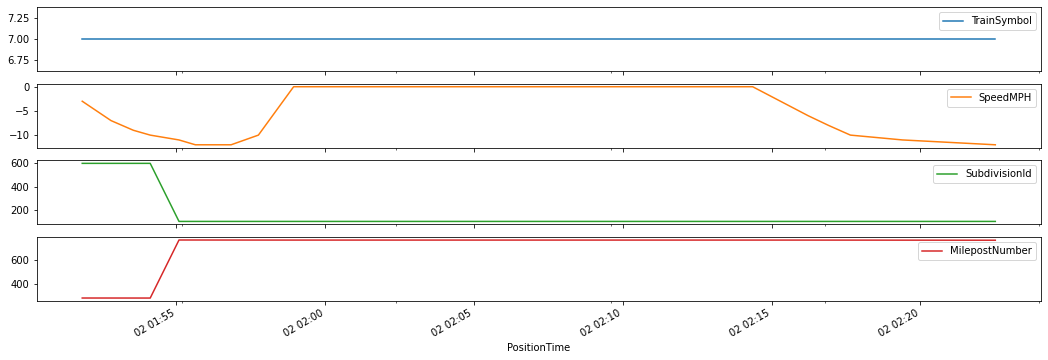

In [8]:
#Evolution of Features over time
config_plot_cols = ['TrainSymbol', 'MaximumTrainSpeed', 'EmptyCarCount', 'LoadedCarCount', 'TrailingTonnage', 'TrainLength']
plot_cols = ['TrainSymbol', 'SpeedMPH', 'SubdivisionId', 'MilepostNumber']

# Plot configuration details by train
config_plot_features = aggregateDataFrame[config_plot_cols]
config_plot_features.index = date_time
_ = config_plot_features[config_plot_cols].groupby('TrainSymbol').first().plot(subplots=True, sharex=True, kind='bar', figsize=(18,6))

plot_features = aggregateDataFrame[plot_cols]
plot_features.index = date_time
_ = plot_features[plot_cols].groupby('TrainSymbol').plot(subplots=True, sharex=True, figsize=(18,6))

plot_features = aggregateDataFrame[plot_cols][:limit]
plot_features.index = date_time[:limit]
_ = plot_features.groupby('TrainSymbol').plot(subplots=True, sharex=True, figsize=(18,6))

In [9]:
# Inspect and clean up - look at statistics of dataset
aggregateDataFrame.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SpeedMPH,2500.0,8.4508,33.058420,-48.0,-23.500000,0.0000,42.000000,58.0000
SubdivisionId,2500.0,113.4484,62.962117,0.0,106.000000,106.0000,106.000000,595.0000
MilepostNumber,2500.0,282.3534,122.677411,0.0,222.781125,261.6436,298.529025,766.9261
TrainSymbol,2500.0,3.0300,2.388175,0.0,0.000000,4.0000,5.000000,7.0000
MaximumTrainSpeed,2500.0,56.1800,4.859737,50.0,50.000000,60.0000,60.000000,60.0000
LoadedCarCount,2500.0,47.2380,53.333771,0.0,0.000000,21.0000,104.000000,126.0000
EmptyCarCount,2500.0,79.7700,58.362656,0.0,0.000000,121.0000,126.000000,126.0000
TrainLength,2500.0,7099.2600,811.729198,5205.0,6682.000000,6835.0000,8287.000000,8406.0000
TrailingTonnage,2500.0,8438.7800,6354.652765,2457.0,2606.000000,5707.0000,14339.000000,18018.0000


Text(0.5, 1.0, 'Time of day signal thing')

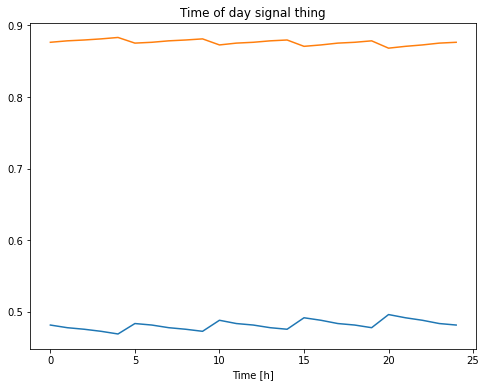

In [10]:
# TODO - Is this needed?

# Date time updates
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

dateTimeDataframe = pd.DataFrame()

dateTimeDataframe['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
dateTimeDataframe['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
dateTimeDataframe['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
dateTimeDataframe['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(dateTimeDataframe['Day sin'])[:25])
plt.plot(np.array(dateTimeDataframe['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal thing')

In [11]:
# Finally get to some training things - split the data

column_indices = {name: i for i, name in enumerate(aggregateDataFrame.columns)}

n = len(aggregateDataFrame)

train_df = aggregateDataFrame[0:int(n*0.7)]
val_df = aggregateDataFrame[int(n*0.7):int(n*0.9)]
test_df = aggregateDataFrame[int(n*0.9):]

num_features = aggregateDataFrame.shape[1]

In [12]:
# Now we normalize the data - required before training a neural network. 

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

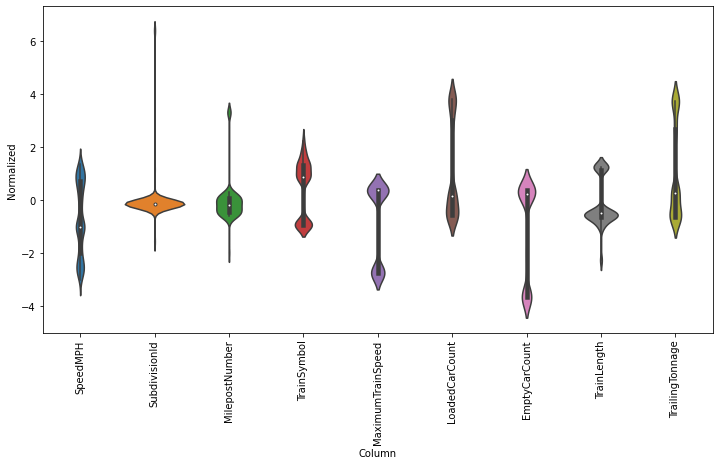

In [13]:
# View distribution of the features - look for obvious errors here

df_std = (aggregateDataFrame - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))

ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(aggregateDataFrame.keys(), rotation=90)

In [14]:
# Data Windowing - done for reuse and for making prediction x hours into the future given y hours of history
# Main features: width of input and label windows, time offset between them, which features are used as inputs, labels or both

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
# Now add code to create 2 windows  (note: try different columns here)

w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['MilepostNumber'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['MilepostNumber']

In [16]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['MilepostNumber'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['MilepostNumber']

In [17]:
# Do some window splitting

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [18]:
# Make use of the window splitting feature
# Note you need enough data for this to work

# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 9)
Inputs shape: (3, 6, 9)
Labels shape: (3, 1, 1)


In [19]:
# Now, plot!

w2.example = example_inputs, example_labels

def plot(self, model=None, plot_col='MilepostNumber', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

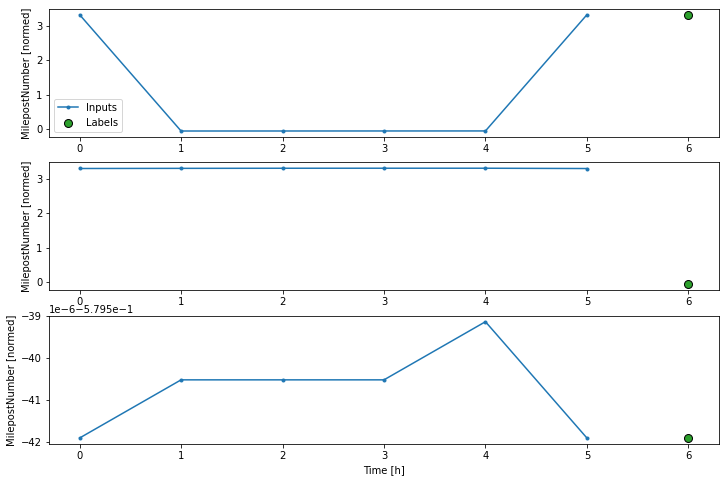

In [20]:
# Here is where we show the plot

w2.plot()

In [21]:
# Make some datasets

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [22]:
# Add properties to the datasets

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [24]:
# The window generator gives us access to the tensor flow dataset objects for easy iteration 

# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [25]:
# let's look at concrete batches

for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [26]:
# Need to configure a window generator to produce single-step pairs

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['MilepostNumber'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['MilepostNumber']

In [27]:
# Once again, look at the batches of date:

for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [28]:
# Build a performance baseline - to use as point for comparison

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [29]:
# Instantiate and evaluate the model:

baseline = Baseline(label_index=column_indices['MilepostNumber'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

16/16 [==============================] - 0s 2ms/step - loss: 3.3145e-04 - mean_absolute_error: 0.0131


In [30]:
# Still, we don't know how well the model is doing. Generate more info

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['MilepostNumber'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['MilepostNumber']

In [31]:
#Now print the shapes

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


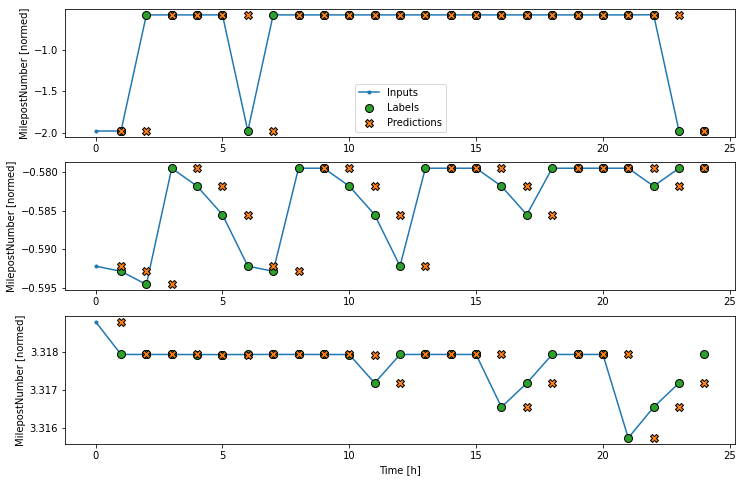

In [32]:
# Finally, plot!

wide_window.plot(baseline)


In [33]:
# Now, let's start looking at a Linear Model! Note that a Dense layer with no activation set is a linear model

linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 9)
Output shape: (32, 1, 1)


In [34]:
# Package training procedure into a function:

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [35]:
# Train the model and evaluate its performance

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
55/55 [==============================] - 1s 7ms/step - loss: 1.6738 - mean_absolute_error: 0.7658 - val_loss: 0.4096 - val_mean_absolute_error: 0.5817
Epoch 2/20
55/55 [==============================] - 0s 7ms/step - loss: 1.3800 - mean_absolute_error: 0.6882 - val_loss: 0.0655 - val_mean_absolute_error: 0.2171
Epoch 3/20
55/55 [==============================] - 0s 8ms/step - loss: 1.1869 - mean_absolute_error: 0.6340 - val_loss: 0.1954 - val_mean_absolute_error: 0.3718
Epoch 4/20
16/16 [==============================] - 0s 3ms/step - loss: 0.4345 - mean_absolute_error: 0.6145


In [36]:
# Again, print the shapes

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


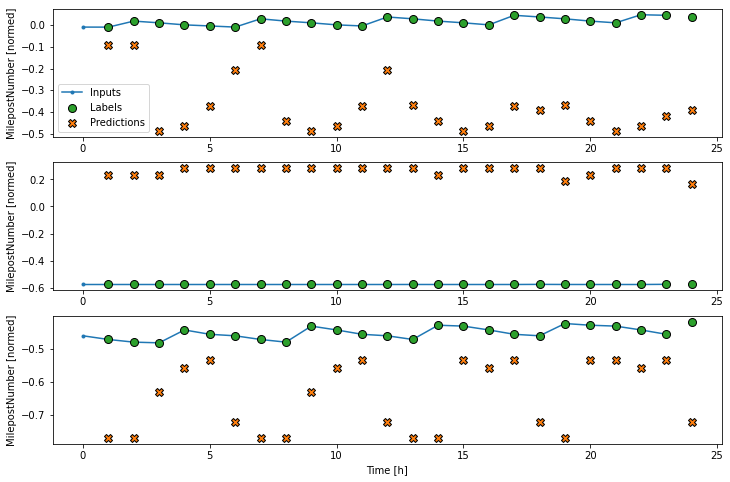

In [ ]:
# And plot

wide_window.plot(linear)


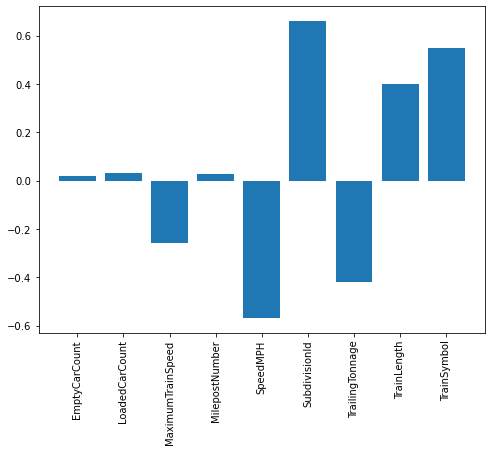

In [ ]:
# Pull out the layer's weights and visualize the weight assigned to each input

plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [ ]:
# Now it's time to look at a Dense model. Note the stacking of layers between input and output

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
55/55 [==============================] - 1s 4ms/step - loss: 0.3722 - mean_absolute_error: 0.3167 - val_loss: 0.2791 - val_mean_absolute_error: 0.5231
Epoch 2/20
55/55 [==============================] - 0s 2ms/step - loss: 0.1966 - mean_absolute_error: 0.1786 - val_loss: 0.1073 - val_mean_absolute_error: 0.3240
Epoch 3/20
55/55 [==============================] - 0s 2ms/step - loss: 0.1892 - mean_absolute_error: 0.1540 - val_loss: 0.0098 - val_mean_absolute_error: 0.0896
Epoch 4/20
55/55 [==============================] - 0s 2ms/step - loss: 0.1898 - mean_absolute_error: 0.1471 - val_loss: 0.0236 - val_mean_absolute_error: 0.1394
Epoch 5/20
16/16 [==============================] - 0s 1ms/step - loss: 0.0601 - mean_absolute_error: 0.2391


In [ ]:
# Create another window generator to produce batches of inputs and labels

CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['MilepostNumber'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['MilepostNumber']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

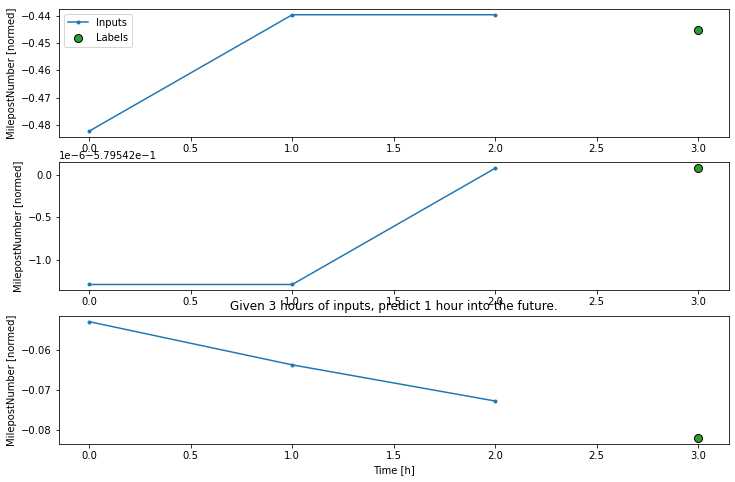

In [ ]:
# Plot!
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [ ]:
# Try adding a flatten layer as the first layer. Why? To possibly train on a multi-input-step window

multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
# Shape time

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


In [ ]:
# Compile and fit the model. Then evaluate

history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

16/16 [==============================] - 0s 902us/step - loss: 0.0416 - mean_absolute_error: 0.1602


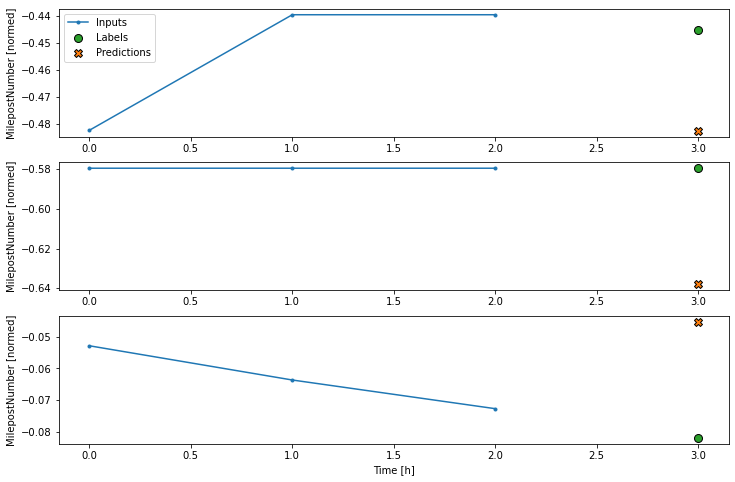

In [ ]:
# Plot time!

conv_window.plot(multi_step_dense)


In [ ]:
# Show what happens if wrong shape is used. Error is expected.

print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 9)

ValueError:Exception encountered when calling layer "sequential_42" (type Sequential).

Input 0 of layer "dense_80" is incompatible with the layer: expected axis -1 of input shape to have value 27, but received input with shape (32, 216)

Call arguments received:
  • inputs=tf.Tensor(shape=(32, 24, 9), dtype=float32)
  • training=None
  • mask=None


In [ ]:
# Convolution Neural Network time! These also take multiple time steps as input to each prediction 

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
# Run on an example batch - does the model produce the expected shape? 

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 9)
Output shape: (32, 1, 1)


In [ ]:
# Train and evaluate the model on the conv_window and it should give similar performance to the multi step dense model:

history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

16/16 [==============================] - 0s 900us/step - loss: 0.0258 - mean_absolute_error: 0.1343


In [ ]:
# Run it on wider input, produce wider output?

print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [ ]:
# We need the labels and prediction to have the same length. So, let's build a WindowGenerator, shall we? 

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['MilepostNumber'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['MilepostNumber']

In [ ]:
# Once again, we can check the shape:

print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


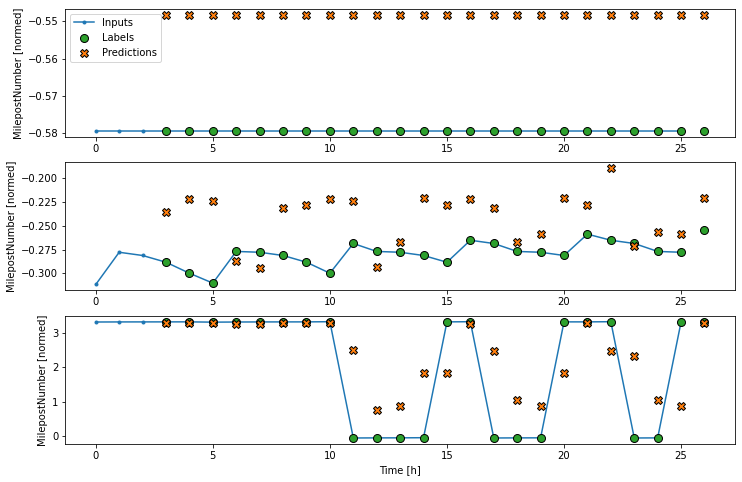

In [ ]:
# And finally, Plot!

wide_conv_window.plot(conv_model)


In [ ]:
# A Recurrent Neural Network is a type of neural network well-suited to time series data. RNNs process a time series step by step.
# We'll use Long short-term memory (LSTM) here

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
# Check out the shapes:

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


In [ ]:
# Compile, fit, and evaluate

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

15/15 [==============================] - 0s 3ms/step - loss: 0.0893 - mean_absolute_error: 0.2569


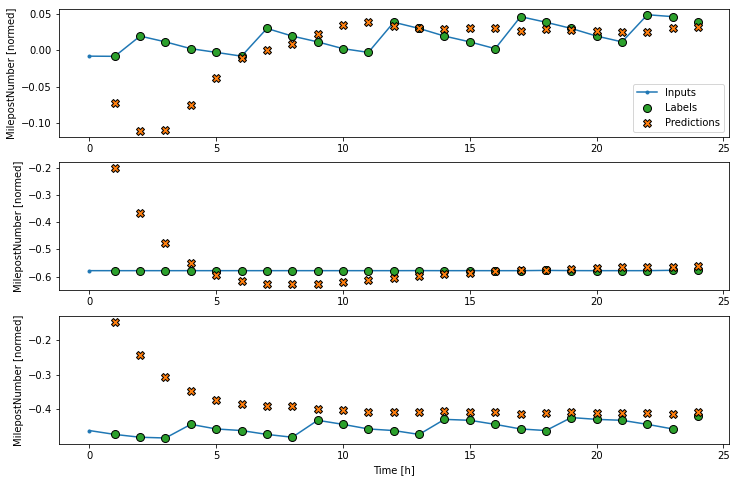

In [ ]:
# Plot to see the results:

wide_window.plot(lstm_model)


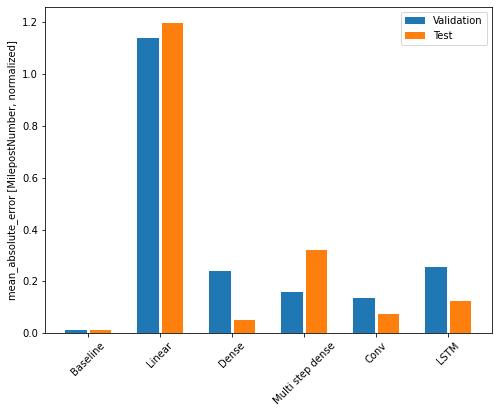

In [ ]:
# Let's do some performance measurements

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [MilepostNumber, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
# Print the values for text comparison

for name, value in performance.items():
  print(f'{name:18s}: {value[1]:0.4f}')

Baseline          : 0.0132
Linear            : 1.1970
Dense             : 0.0504
Multi step dense  : 0.3198
Conv              : 0.0745
LSTM              : 0.1251


In [ ]:
# What do multi-output models look like? Can we predict multiple features? Yes, just change the number of units in the output layer,
# and adjust the training windows to inlude all features in the labels 

single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 9)
Labels shape (batch, time, features): (32, 24, 9)


In [ ]:
# So, let's do it with Baseline

baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
# evaulate! 

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

15/15 [==============================] - 0s 750us/step - loss: 0.0092 - mean_absolute_error: 0.0209


In [ ]:
# Now do the Dense model:

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
# evaluate 

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

16/16 [==============================] - 0s 933us/step - loss: 0.0534 - mean_absolute_error: 0.1840


In [ ]:
# Finally, the RNN with LSTM

%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

UsageError: Line magic function `%%time` not found.


In [ ]:
# Look at a Residual Network - each layer adds to the model's accumulating result

# Here we create the utility class

class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
# and here we do the evaluation

%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

UsageError: Line magic function `%%time` not found.


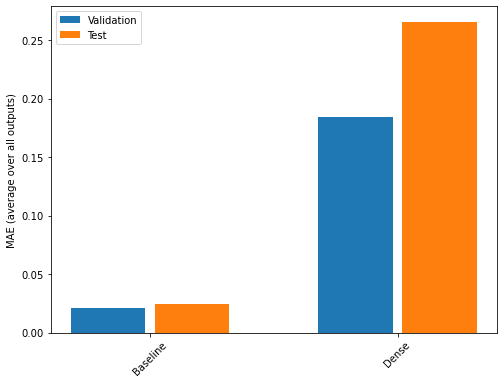

In [ ]:
# Once again, let's look at model performance comparison, now with more layers! (new and improved ;))
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
# Text comparison

for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.0241
Dense          : 0.2656


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

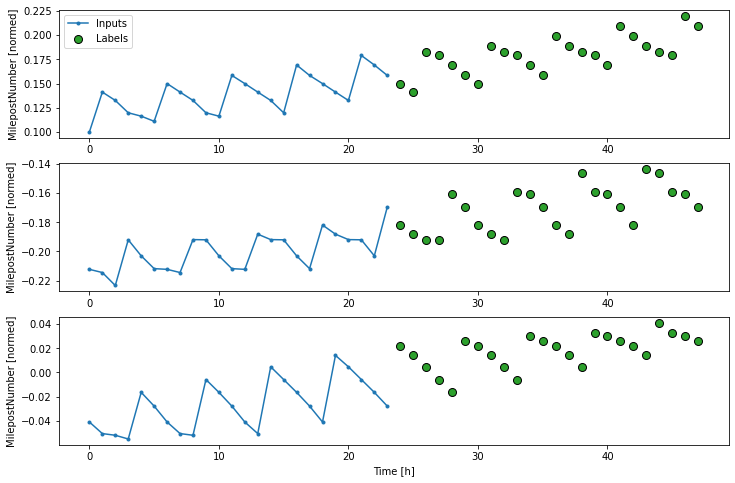

In [ ]:
# Begin looking at multi step models. The idea is to do multiple time step predictions. The model needs to learn to predict 
# a range of future values, like a sequence.  Think of predicting 24 hours into the future, given 24 hours of the past

OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

15/15 [==============================] - 0s 857us/step - loss: 0.0160 - mean_absolute_error: 0.0301


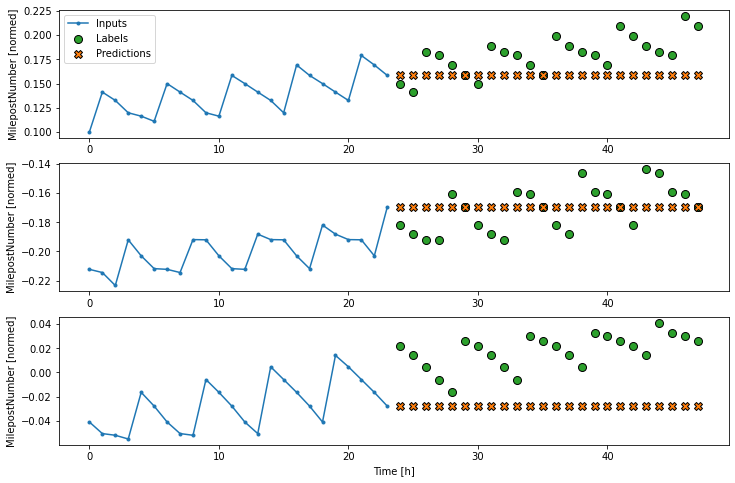

In [ ]:
# Create a function to repeat the last input time step for some number of output time steps

class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

15/15 [==============================] - 0s 859us/step - loss: 0.0212 - mean_absolute_error: 0.0355


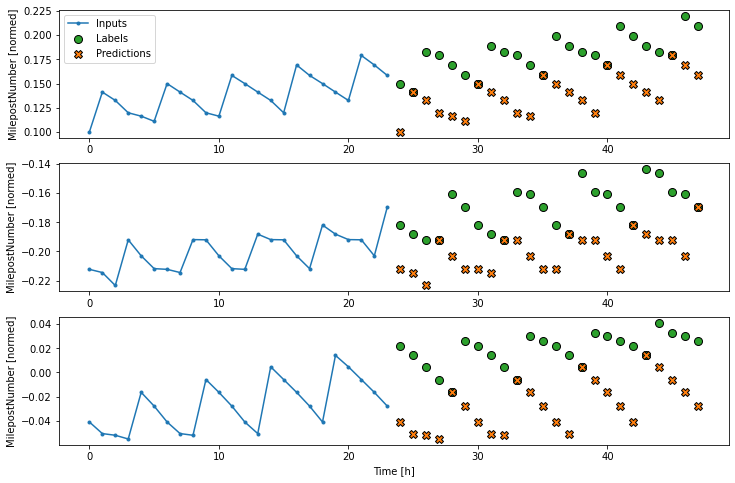

In [ ]:
# Now create a function to repeat the baseline

class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

15/15 [==============================] - 0s 893us/step - loss: 0.1642 - mean_absolute_error: 0.3273


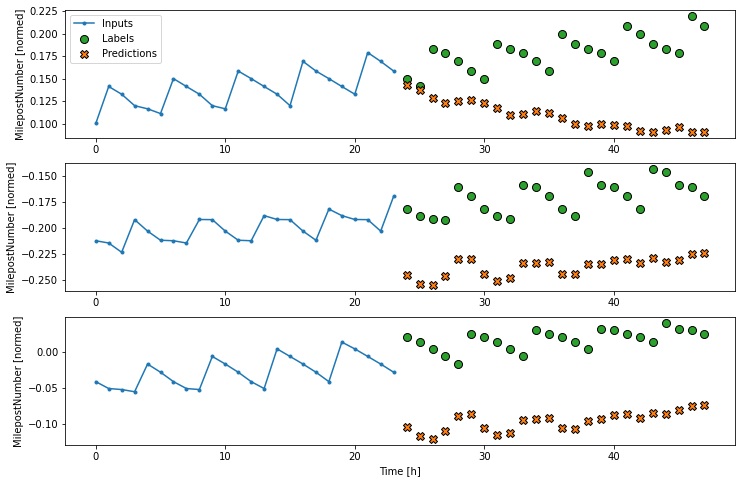

In [ ]:
# Here is a linear model 

multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

15/15 [==============================] - 0s 1ms/step - loss: 0.0400 - mean_absolute_error: 0.1382


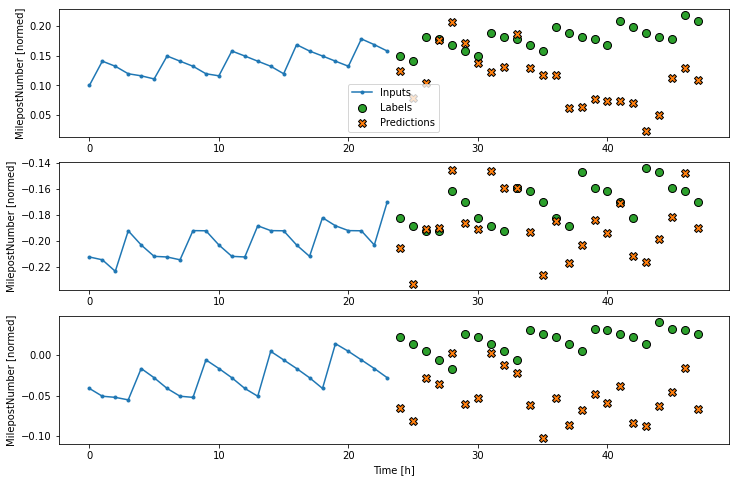

In [ ]:
# Here is a dense model

multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

15/15 [==============================] - 0s 1ms/step - loss: 0.0568 - mean_absolute_error: 0.1981


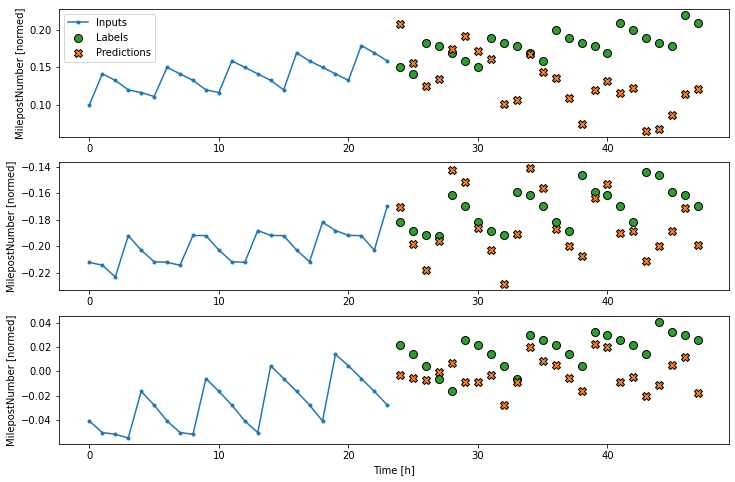

In [ ]:
# Here is a CNN model 

CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

15/15 [==============================] - 0s 2ms/step - loss: 0.0750 - mean_absolute_error: 0.2039


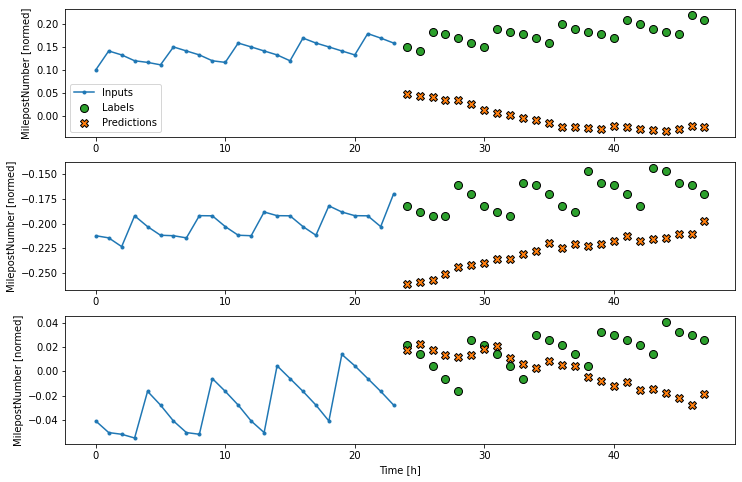

In [ ]:
# And here is an RNN model

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
# Feedback function

class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)


In [ ]:
# warmup to initialize the internal state, based on the inputs

def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
# So, what's the shape look like now? 

prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 9])

In [ ]:
# Do the actual prediction - having to collect output predictions and retain them while iterating through each step

def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
# Run on example inputs and see the shape:

print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)


Output shape (batch, time, features):  (32, 24, 9)


15/15 [==============================] - 0s 3ms/step - loss: 0.0756 - mean_absolute_error: 0.1684


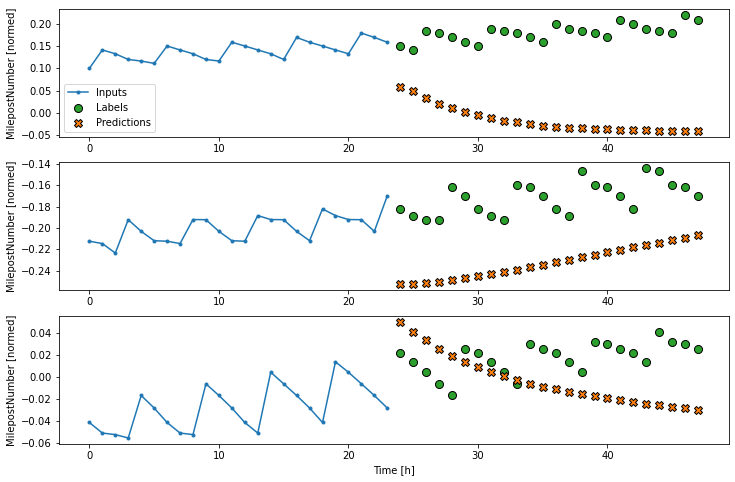

In [ ]:
# Now train the model

history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

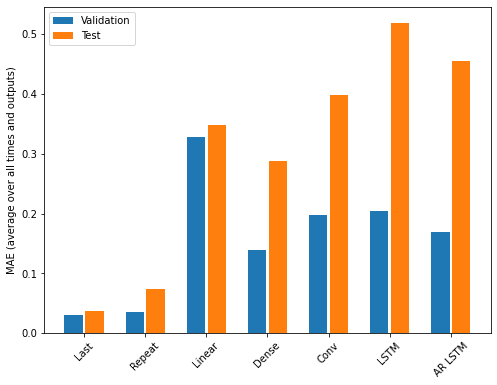

In [ ]:
# Evaluate Performance

x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
# Text output for easy comparison 

for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.0364
Repeat  : 0.0746
Linear  : 0.3481
Dense   : 0.2877
Conv    : 0.3987
LSTM    : 0.5195
AR LSTM : 0.4551
